In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
%matplotlib inline

from keras.callbacks import LearningRateScheduler, History
from keras.optimizers import Adam
from keras.models import Model
from keras.losses import categorical_crossentropy, hinge

import tensorflow as tf

Using TensorFlow backend.


In [2]:
import sys
sys.path.append('/home/albert/github/DenseNet/')
import densenet
sys.path.append('/home/albert/github/tensorflow/src/')
import triplet
import evaluation
import data
import dense

### Data

In [3]:
train_dict, train_files = data.get_data('train', keypoints=['Neck'])

preprocess True
keypoints ['Neck']
0.54175901413


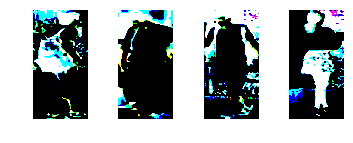

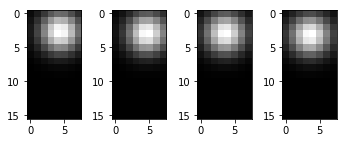

In [4]:
start = time.time()
batch = data.output_batch_generator(train_dict, P=4, K=3, preprocess=True,
                                    shape=(256,128), keypoints=['Neck'], 
                                    cam_output_dim=(16,8), rect=False).next()
print time.time() - start

plt.figure(figsize=(15,2))
for i in range(4):
    plt.subplot(1,10,i+1)
    plt.imshow(batch[0]['input_im'][i].astype(np.uint8))
    plt.axis('off')
plt.show()

import cv2
plt.figure(figsize=(15,2))
for i in range(4):
    plt.subplot(1,10,i+1)
    im = batch[1]['cam_output'][i].squeeze()
    plt.imshow(im, cmap=plt.cm.gray)
    plt.axis('on')
plt.show()

### Train Network

In [5]:
steps_per_epoch = 100

input_shape = (256,128)

preprocess = True

In [6]:
file_root = 'spn_neck'
if os.path.exists('/home/albert/github/tensorflow/models/%s' % file_root) == False:
    os.system('mkdir /home/albert/github/tensorflow/models/%s' % file_root)

In [7]:
# First integer: number of epochs (e.g., 10)
# Second integer: era

epochs = 10

step_decay_cont_str = """
def step_decay_cont(epoch, init_epoch=%d*(%d - 1), init_lr=0.0003):
    drop = 0.5
    epochs_drop = 10.0
    t1 = 50.0
    if epoch + init_epoch < t1:
        lrate = init_lr
    else:
        lrate = init_lr * np.power(drop,  
               np.floor((epoch + init_epoch - t1 + epochs_drop)/(epochs_drop)))
    return lrate
"""

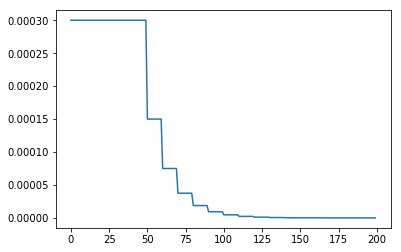

In [8]:
lr = []
for era in range(1,21):
    exec(step_decay_cont_str % (epochs, era))
    for j in range(10):
        lr.append(step_decay_cont(j))
plt.plot(np.arange(200), lr)

In [9]:
P_param = 4
K_param = 3

def_triplet_loss = """

import keras.backend as Keras

def triplet_loss(y_true, y_pred, margin=1.0, P=%d, K=%d, output_dim=%d):
    embeddings = Keras.reshape(y_pred, (-1, output_dim))
    loss = Keras.variable(0, dtype='float32')

    for i in range(P):
        for a in range(K):
            pred_anchor = embeddings[i*K + a]
            hard_pos = Keras.max(triplet.dist(pred_anchor, embeddings[i*K:(i + 1)*K]))
            hard_neg = Keras.min(triplet.dist(pred_anchor, Keras.concatenate([embeddings[0:i*K],
                                                                    embeddings[(i + 1)*K:]], 0)))
            if margin == 'soft':
                loss += triplet.log1p(hard_pos - hard_neg)
            else:
                loss += Keras.maximum(margin + hard_pos - hard_neg, 0.0)
    return loss
""" % (P_param, K_param, 128)

exec(def_triplet_loss)

def cam_loss(y_true, y_pred, P=P_param, K=K_param, cam_dim=(8,4)):
#     return tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred)
#     return Keras.sum(Keras.flatten(tf.multiply(y_true, y_pred)))
    return tf.losses.hinge_loss(labels=y_true, logits=y_pred)

In [10]:
trinet = dense.DenseNetImageNet121(input_shape=(256,128,3), weights='imagenet')

Weights for the model were loaded successfully


In [30]:
# https://stackoverflow.com/questions/43284897/how-can-i-multiply-a-vector-and-a-matrix-in-tensorflow-without-reshaping

from keras.layers import Lambda

def L(a,b, e=2):
    return Keras.exp(-(a**2 + b**2)/(2*e**2))

def cam(pool, cam_dim=(8,4), P=P_param, K=K_param):    
    batch_size = P * K
    height = cam_dim[0]
    width = cam_dim[1]
    channels = pool.get_shape()[3].value

    norms = []
    for b in range(batch_size):
        for i in range(height):
            for j in range(width):
#                 for p in range(height):
#                     for k in range(width):
                norms.append(triplet.norm(pool[b][i][j], tf.reshape(pool[b], (height*width, channels)), axis=1))
#                 norms = tf.concat([norms, n], 1)
#     triplet.norm(tf.reshape(pool, (-1, height * width, 1, channels)), 
#                          tf.tile(tf.reshape(pool,(-1, 1, height * width, channels)), 
#                                  [1, height * width, 1, 1]), axis=3)

    L_x = tf.reshape(tf.tile(tf.range(0, width, delta=1, dtype=tf.float32), [height]), (1,1, height*width))
    L_x_0 = tf.tile(tf.reshape(L_x, (1, height * width, 1)), [batch_size,1,1])
    L_x_1 = tf.tile(L_x, [batch_size, height * width, 1])

    L_y = tf.reshape(tf.tile(tf.reshape(tf.range(0, height, delta=1, dtype=tf.float32), 
                                        (1,height,1)), [1,1,width]), (1,height*width,1))
    L_y_0 = tf.tile(L_y, [batch_size,1, 1])
    L_y_1 = tf.tile(tf.reshape(L_y, (1,1,height*width)), [batch_size, height * width, 1])

    L_maps = L(L_x_0 - L_x_1, L_y_0-L_y_1)
    
    D = tf.multiply(tf.reshape(tf.stack(norms), (batch_size, height*width, height*width)), L_maps)
    D = tf.divide(D, tf.tile(tf.reshape(tf.reduce_sum(D, axis=2), (-1, height * width, 1)), [1,1, height * width]))
    
    D = tf.transpose(D, (0,2,1))
    M = tf.convert_to_tensor(np.ones((batch_size, height * width,), dtype=np.float32) / (height * width))
    M = tf.expand_dims(M,2) 
    
    for i in range(1):
         M = tf.matmul(D, M)
    
    return tf.reshape(M, (P*K,cam_dim[0], cam_dim[1]))

cam_output = Lambda(cam, name='cam_output', arguments={'P' : 1, 'K' : 1})(trinet.layers[-6].output)

In [31]:
camnet = Model(inputs=trinet.input, outputs=[trinet.output, cam_output])
camnet.compile(loss=[triplet_loss, cam_loss], loss_weights=[1.0, 25.0],
               optimizer=Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0))

# camnet = Model(inputs=trinet.input, outputs=[trinet.output])
# camnet.compile(loss=[triplet_loss],
#                optimizer=Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0))

In [32]:
camnet.output

[<tf.Tensor 'final_output/BiasAdd:0' shape=(?, 128) dtype=float32>,
 <tf.Tensor 'cam_output_6/Reshape_39:0' shape=(1, 8, 4) dtype=float32>]

In [14]:
camnet.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_im (InputLayer)            (None, 256, 128, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 128, 64, 64)   9408        input_im[0][0]                   
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 128, 64, 64)   256         conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 128, 64, 64)   0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [10]:
b = batch[0]['input_im']
spn = camnet.predict(b)

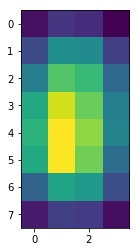

In [14]:
plt.imshow(spn[1][0].reshape((8,4)))

In [15]:
# def L(a,b, e=2):
#     return np.exp(-(a**2 + b**2)/(2*e**2))

# def norm(x1, x2, axis=1, norm=1):
#     return np.power(np.sum(np.power(np.abs(x1 - x2), norm), axis=axis), 1.0 / norm)

# pool_model = Model(inputs=camnet.input, outputs=camnet.layers[-7].output)
# pool_model.compile(loss=hinge, 
#                optimizer=Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0))

# pool = pool_model.predict(batch[0]['input_im'][5].reshape((-1, 256,128,3)))

# height = pool.shape[1]
# width = pool.shape[2]

# norms = norm(pool.reshape((-1, height * width, 1, pool.shape[3])), 
#              np.tile(pool.reshape((-1, 1, height * width, pool.shape[3])), [1, height * width, 1, 1]), axis=3)

# L_x = np.tile(np.arange(0, width, 1, float), height).reshape((1,1, height*width))
# L_x_0 = np.tile(L_x.reshape((1, height * width, 1)), [pool.shape[0],1,1])
# L_x_1 = np.tile(L_x, [pool.shape[0],height * width, 1])

# L_y = np.arange(0, height, 1, float).repeat(width).reshape((1,1, height*width))
# L_y_0 = L_y.reshape((1,height * width, 1))
# L_y_1 = np.tile(L_y, [pool.shape[0],height * width, 1])

# L_maps = L(L_x_0 - L_x_1, L_y_0-L_y_1)

# D = np.multiply(norms, L_maps)

# D = np.divide(D, np.tile(np.sum(D, axis=2).reshape((-1, height * width, 1)), [1,1, height * width]))

# D = np.matrix(D)
# D = np.matrix.transpose(D)
# M = np.matrix(np.ones((height * width,), dtype=np.float64) / D.shape[0])

# M = M * np.matrix.transpose(D)

# plt.imshow(M.reshape((16,8)))

In [9]:
camnet = dense.SPN(4,3, weights='imagenet')

Weights for the model were loaded successfully


In [16]:
import keras
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.loss = []
        self.final_output_loss = []
        self.cam_output_loss = []
        
    def on_epoch_end(self, epoch, logs={}):
#         print logs.keys()
        self.loss.append(logs['loss'])
        self.final_output_loss.append(logs['final_output_loss'])
        self.cam_output_loss.append(logs['cam_output_loss'])
    
    def on_train_end(self, logs={}):
        print self.loss, self.final_output_loss, self.cam_output_loss

In [17]:
model_json = camnet.to_json()
with open("/home/albert/github/tensorflow/models/%s/%s.json" % (file_root, file_root), "w") as json_file:
    json_file.write(model_json)

In [18]:
# camnet.set_weights(np.load('/home/albert/github/tensorflow/models/densenet_cam_l1_test/densenet_cam_l1_test_5000.npy'))

In [19]:
train_score = {}
hist = {'loss' : [], 'final_output_loss' : [], 'cam_output_loss' : []}
history = History()
loss = LossHistory()

In [20]:
for era in range(1,16):
    iterations = era * steps_per_epoch * epochs
    exec(step_decay_cont_str % (epochs, era))
    lrate = LearningRateScheduler(step_decay_cont)
    
    camnet.fit_generator(data.output_batch_generator(train_dict, P=P_param, K=K_param, preprocess=True,
                                    shape=(256,128), keypoints=['Neck'], 
                                    cam_output_dim=(8,4), rect=False), 
                         steps_per_epoch=steps_per_epoch,
                         epochs=epochs,
                         callbacks=[lrate, history, loss])
    
    file_name = file_root + '_' + str(iterations) + '.npy'
    np.save('/home/albert/github/tensorflow/models/%s/%s' % (file_root, file_name), camnet.get_weights())
    
    
    train_score[iterations] = evaluation.get_score(camnet, hist=history, preprocess=preprocess)
    
    hist['loss'] += loss.loss
    hist['final_output_loss'] += loss.final_output_loss
    hist['cam_output_loss'] += loss.cam_output_loss
    
    print iterations, train_score[iterations]

preprocess True
keypoints ['Neck']
Epoch 1/10
100/100 [==============================] - 63s - loss: 203.2765 - final_output_loss: 177.5434 - cam_output_loss: 1.0169    
Epoch 2/10
100/100 [==============================] - 57s - loss: 156.3753 - final_output_loss: 130.6458 - cam_output_loss: 1.0166    
Epoch 3/10
100/100 [==============================] - 57s - loss: 124.6006 - final_output_loss: 98.8712 - cam_output_loss: 1.0165    
Epoch 4/10
100/100 [==============================] - 57s - loss: 122.8458 - final_output_loss: 97.1190 - cam_output_loss: 1.0163    
Epoch 5/10
100/100 [==============================] - 57s - loss: 114.1935 - final_output_loss: 88.4664 - cam_output_loss: 1.0163    
Epoch 6/10
100/100 [==============================] - 57s - loss: 104.5335 - final_output_loss: 78.7991 - cam_output_loss: 1.0165    
Epoch 7/10
100/100 [==============================] - 57s - loss: 98.1148 - final_output_loss: 72.3840 - cam_output_loss: 1.0164    
Epoch 8/10
100/100 [======

InvalidArgumentError: slice index 1 of dimension 0 out of bounds.
	 [[Node: cam_output/strided_slice_128 = StridedSlice[Index=DT_INT32, T=DT_FLOAT, begin_mask=0, ellipsis_mask=0, end_mask=0, new_axis_mask=0, shrink_axis_mask=1, _device="/job:localhost/replica:0/task:0/gpu:0"](activation_121/Relu, cam_output/strided_slice_128/stack, cam_output/strided_slice_128/stack_1, cam_output/strided_slice_128/stack_2)]]
	 [[Node: final_output/BiasAdd/_6691 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_25783_final_output/BiasAdd", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op u'cam_output/strided_slice_128', defined at:
  File "/home/albert/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/albert/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/albert/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/albert/anaconda2/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/albert/anaconda2/lib/python2.7/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/albert/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/albert/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/albert/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/albert/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/albert/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/albert/anaconda2/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/albert/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/albert/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/albert/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-2cdc2899de29>", line 49, in <module>
    cam_output = Lambda(cam, name='cam_output')(trinet.layers[-6].output)
  File "/home/albert/anaconda2/lib/python2.7/site-packages/keras/engine/topology.py", line 602, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/albert/anaconda2/lib/python2.7/site-packages/keras/layers/core.py", line 650, in call
    return self.function(inputs, **arguments)
  File "<ipython-input-11-2cdc2899de29>", line 20, in cam
    norms.append(triplet.norm(pool[b][i][j], tf.reshape(pool[b], (height*width, channels)), axis=1))
  File "/home/albert/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/array_ops.py", line 509, in _SliceHelper
    name=name)
  File "/home/albert/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/array_ops.py", line 677, in strided_slice
    shrink_axis_mask=shrink_axis_mask)
  File "/home/albert/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3744, in strided_slice
    shrink_axis_mask=shrink_axis_mask, name=name)
  File "/home/albert/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/albert/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/albert/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): slice index 1 of dimension 0 out of bounds.
	 [[Node: cam_output/strided_slice_128 = StridedSlice[Index=DT_INT32, T=DT_FLOAT, begin_mask=0, ellipsis_mask=0, end_mask=0, new_axis_mask=0, shrink_axis_mask=1, _device="/job:localhost/replica:0/task:0/gpu:0"](activation_121/Relu, cam_output/strided_slice_128/stack, cam_output/strided_slice_128/stack_1, cam_output/strided_slice_128/stack_2)]]
	 [[Node: final_output/BiasAdd/_6691 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_25783_final_output/BiasAdd", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [ ]:
# np.save('/home/albert/history.npy', hist)

In [ ]:
np.savez('/home/albert/github/tensorflow/models/%s/%s_score.npz' % (file_root, file_root), train_score)

### Evaluation

In [ ]:
evaluation.plot_rank('densenet_cam', ylim_0=0.0)

In [ ]:
evaluation.plot_loss('densenet_cam')

In [ ]:
evaluation.plot_rank('densenet_triplet_front', ylim_0=0.0)